**Dataset Story :**
* The Online Retail II data set, which includes the sales data of the UK-based online sales store, was used.
* Sales data between 01/12/2009 - 09/12/2011 are included in the data set.
* The product catalog of this company includes souvenirs.
* There is also information that most of its customers are wholesalers.

**Variables:**
* InvoiceNo: Invoice Number -> If this code starts with C, it means that the operation has been canceled.
* StockCode: Product Code -> Unique number for each product
* Description: Product name
* Quantity: Number of products -> how many of the products on the invoices were sold.
* InvoiceDate
* UnitePrice
* CustomerID: Unique customer number
* Country

In [1]:
! pip install openpyxl

     |████████████████████████████████| 243 kB 827 kB/s 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import openpyxl
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

###############################################################
#       Importing / Pre-Processing         #
###############################################################

In [3]:
df = pd.read_excel('/kaggle/input/online-retail/online_retail.xlsx', sheet_name="Year 2010-2011", engine='openpyxl')

In [4]:
# Let's next step: Checking Null values:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [5]:
# Check df:
print(f"Total number of observations:, {df.shape[0]}")
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
print(f"Categorical Variables:,{len(cat_cols)}:{cat_cols}")
num_cols = [col for col in df.columns if df[col].dtypes != "O"]
print(f"Numerical Variables:,{len(num_cols)}:{num_cols}")
num_but_num = [col for col in df.columns if df[col].nunique() < 4500 and df[col].dtypes != "O"]
print(f"Numerical Variables:,{len(num_but_num)}:{num_but_num}")
date_time = [col for col in df.columns if df[col].dtypes == "datetime64[ns]"]
print(f"Datetime Variables:,{len(date_time)}:{date_time}")

Total number of observations:, 541910
Categorical Variables:,4:['Invoice', 'StockCode', 'Description', 'Country']
Numerical Variables:,4:['Quantity', 'InvoiceDate', 'Price', 'Customer ID']
Numerical Variables:,3:['Quantity', 'Price', 'Customer ID']
Datetime Variables:,1:['InvoiceDate']


In [6]:
# Pre-Processing the dataset
df.isnull().sum()
# Drop null:
df.dropna(inplace=True)
# Check df:
df.shape
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,3,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,3,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3,17850,United Kingdom


###############################################################
#       Calculating RFM Metrics          #
###############################################################


In [7]:
# Recency: How recently a customer has made a purchase (Today - Last Transaction Day)
# Frequency: How often a customer makes a purchase
# Monetary Value: How much money a customer spends on purchases

In [8]:
df["InvoiceDate"].max()   
df["InvoiceDate"].min()
thisday=dt.datetime(2011, 12, 12)

In [9]:
rfm_ = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (thisday-date.max()).days,
                                     'Invoice': lambda num: len(num),
                                     'Price': lambda Price: Price.sum()})

rfm_.columns = ['Recency', 'Frequency', 'Monetary']

rfm_ = rfm_[(rfm_["Monetary"]) > 0 & (rfm_["Frequency"] > 0)]
rfm_.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346,327,2,2
12347,4,182,481
12348,77,31,179
12349,20,73,605
12350,312,17,65


In [10]:
# Scaling:
rfm_["Recency_Score"] = pd.qcut(rfm_['Recency'], 5, labels=[5, 4, 3, 2, 1])# 1 gün önce geldiyse 5 puan
rfm_["Frequency_Score"] = pd.qcut(rfm_['Frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_["Monetary_Score"] = pd.qcut(rfm_['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [11]:
# New column is created:"RFMSCORE"
rfm_["RFMSCORE"] = (rfm_['Recency_Score'].astype(str)+rfm_['Frequency_Score'].astype(str)+rfm_['Monetary_Score'].astype(str))

In [12]:
rfm_.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMSCORE
Customer ID,,,,,,,
12346,327,2,2,1,1,1,111
12347,4,182,481,5,5,5,555
12348,77,31,179,2,3,3,233
12349,20,73,605,4,4,5,445
12350,312,17,65,1,2,2,122


In [13]:
segment_map = { 
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At_Risk',
    r'[1-2]5': 'Cant_Loose',
    r'3[1-2]': 'About_to_Sleep',
    r'33': 'Need_Attention',
    r'[3-4][4-5]': 'Loyal_Customers',
    r'41': 'Promising',
    r'51': 'New_Customers',
    r'[4-5][2-3]': 'Potential_Loyalists',
    r'5[4-5]': 'Champions'}

rfm_['Segment'] = rfm_['Recency_Score'].astype(str) + rfm_['Frequency_Score'].astype(str)

rfm_['Segment'] = rfm_['Segment'].replace(segment_map, regex=True)

In [14]:
rfm_.reset_index(inplace=True)
rfm_.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMSCORE,Segment
0,12346,327,2,2,1,1,1,111,Hibernating
1,12347,4,182,481,5,5,5,555,Champions
2,12348,77,31,179,2,3,3,233,At_Risk
3,12349,20,73,605,4,4,5,445,Loyal_Customers
4,12350,312,17,65,1,2,2,122,Hibernating


**** K MEANS ****

In [15]:
# Selected for RFM columns
df = rfm_[['Customer ID', 'Recency', 'Frequency', 'Monetary']]

In [16]:
# 0-1 Recency - Frequency - Monetary scaling:
sc = MinMaxScaler((0, 1))
df[['Recency', 'Frequency', 'Monetary']] = sc.fit_transform(df[['Recency', 'Frequency', 'Monetary']])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [17]:
df.head()

,Customer ID,Recency,Frequency,Monetary
0,12346,1,0,0
1,12347,0,0,0
2,12348,0,0,0
3,12349,0,0,0
4,12350,1,0,0


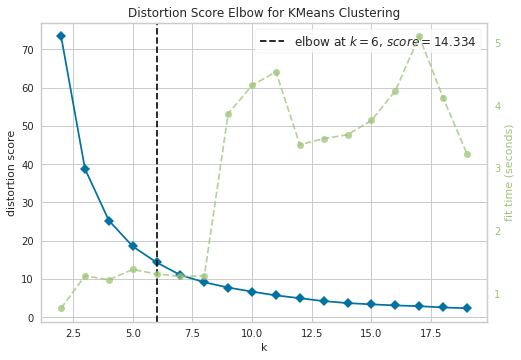

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# Determining Cluster, k=6
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df[['Recency', 'Frequency', 'Monetary']])
elbow.show()

In [19]:
# Kmeans fitting for model 

kmeans = KMeans(n_clusters=6).fit(df[['Recency', 'Frequency', 'Monetary']])
kumeler = kmeans.labels_


In [20]:
# "kumeler" is added as array to "cluster no":
rfm_["cluster_no"] = kumeler

# Cluster No is starting with 1:
rfm_["cluster_no"] = rfm_["cluster_no"] + 1

# Let's checking:
rfm_.head()

# Grouping by Recency - Frequency - Monetary:
rfm_.groupby("cluster_no").agg(['count', 'mean']).reset_index()

cluster_no Customer ID       Recency      Frequency      Monetary      
                   count  mean   count mean     count mean    count  mean
0          1        1010 15247    1010   75      1010   55     1010   174
1          2         427 15315     427  250       427   25      427    92
2          3        2111 15301    2111   19      2111  137     2111   420
3          4         516 15376     516  162       516   40      516   160
4          5         300 15336     300  338       300   23      300    85
5          6           7 14781       7   42         7 3452        7 28198

In [21]:
# Finally: RFM and Clustering via K means method
rfm_.head()

,Customer ID,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFMSCORE,Segment,cluster_no
0,12346,327,2,2,1,1,1,111,Hibernating,5
1,12347,4,182,481,5,5,5,555,Champions,3
2,12348,77,31,179,2,3,3,233,At_Risk,1
3,12349,20,73,605,4,4,5,445,Loyal_Customers,3
4,12350,312,17,65,1,2,2,122,Hibernating,5
